<a href="https://colab.research.google.com/github/RDW287/CM3710-Coding-Assessment/blob/main/AI_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/RDW287/CM3710-Coding-Assessment
%cd CM3710-Coding-Assessment/
!git pull

fatal: destination path 'CM3710-Coding-Assessment' already exists and is not an empty directory.
/content/CM3710-Coding-Assessment
Already up to date.


#**Introduction**

The aim of this notebook is to create and compare to two AI algorithms to classify images from the selected dataset. The dataset is images captured using Meta glass, these include rooms and objects within RGU that are categorized/labelled by name.

In [8]:
# Required imports for code
import os
import re
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split

No. Images:  98
Image Size: (360, 360)


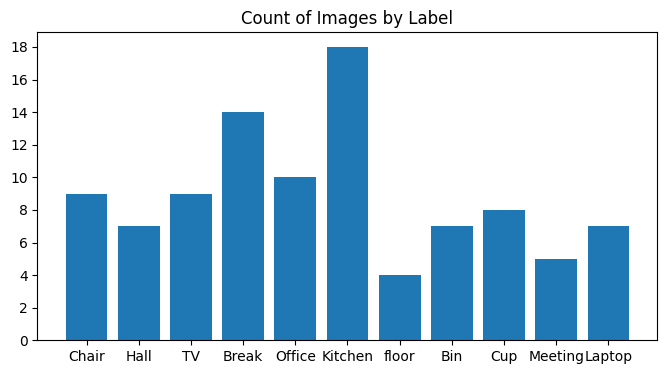

In [4]:
# Data Exploration

directory = "RGU_Images" #The name of the folder containing the images

# Stores the names of the files, this will be used as the labels later
image_filenames = []
files = os.listdir(directory)
for file in files:
  name = re.split('_|-', file) #Splits file names by _ and - to get the label as the names are like 1-Bin_1.jpeg
  image_filenames.append(name[1])

# We can see that we have 98 images that are 360x360 pixels in size
print("No. Images: ", len(files))
print("Image Size:", Image.open(f'{directory}/{files[0]}').size)

# Gets the count of each label in the dataset
filename_count = Counter(image_filenames)

# The bar graph below shows that not all categories have equal amounts of images, 'floor' only has 4 whereas 'kitchen' has 18. In order to help the algorithms learn we should augment these images in the model to increase the dataset size.
plt.figure(figsize=(8,4))
plt.bar(filename_count.keys(), filename_count.values())
plt.yticks(range(0,20,2))
plt.title("Count of Images by Label")
plt.show()

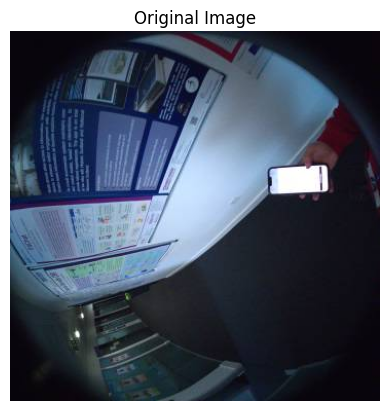

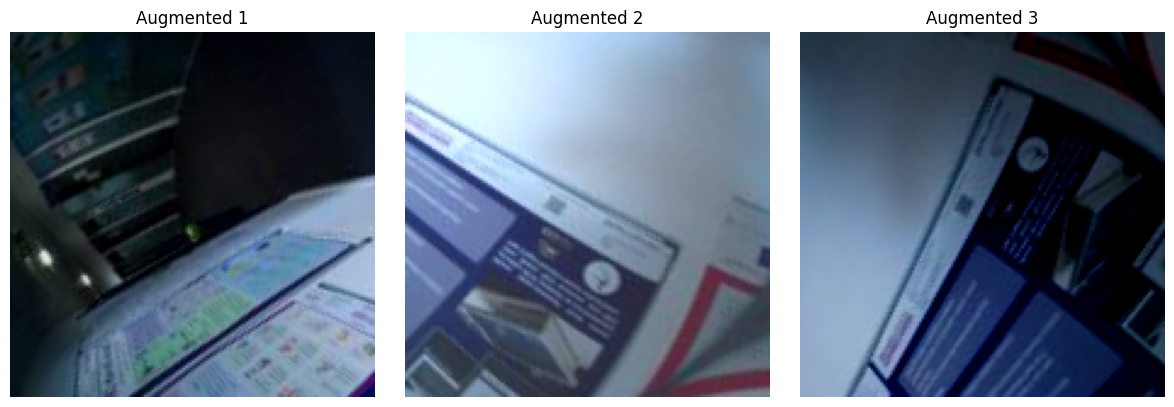

In [44]:
# Data Preprocessing

# We will create a keras layer to apply augmentation techniques to expand our training set
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"), #Flips the image horizontally and/or vertically
    tf.keras.layers.RandomRotation(0.5), #Adds some rotation to the image
    tf.keras.layers.RandomCrop(150,150), #Zooms into a particular point by cropping the rest of the image
    tf.keras.layers.RandomBrightness(factor=0.2), #Changes the brightness of the image
    tf.keras.layers.Rescaling(1./255) #This will scale the image contents to between 0-1, this is min-max normalisation
])

# This is what the original image looks like
img = plt.imread(f'{directory}/{files[1]}')
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

# These are examples of how the images will look after augmentation
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    augmented = data_augmentation(img)
    axs[i].imshow(augmented)
    axs[i].set_title(f"Augmented {i + 1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [64]:
# Now we need to create our dataset with the augmented images
images = []
for file in files:
  image = Image.open(f'{directory}/{file}')
  images.append(np.array(image) / 255) #We need to make sure we preprocess the data, this is also handled by the augmentation
images = np.array(images) #We will use a numpy array for compatability with future methods

# We need to convert the labels from the file names into one-hot vectors, it will create an n length array with 0 in every column apart from the one where it matches the label
y_categorical = tf.keras.utils.to_categorical(
    np.unique(image_filenames, return_inverse=True)[1]
)
print("Categorical Vector Example:", y_categorical[0])

# A train test split will be used to leave 30% of the training set as unseen data for testing. This prevents overfitting of the model and allows us to test its suitability on unseen images
X_train, X_test, y_train, y_test = train_test_split(
    images,
    y_categorical,
    test_size=0.3, #30% of the entire dataset is set aside, this will not include augmented images as this would cause accuracy overestimation due to small parts of the training data being in the test set
    stratify=y_categorical, #This is a sampling method to help preserve the proportions in our data, it prevents certain low occurring categories not appearing in our test at all
    random_state=101
)

# Now we need to add in our augmented data into our training set, we did this after the split to prevent pieces of training data sneaking into our test set
print(len(X_train))
for x,y in zip(X_train, y_train):
  for j in range(5): #We will create 5 augmented images for each image in our train set
    augmented = np.array(data_augmentation(x))
    print(augmented.shape,X_train.shape)
    X_train = np.append(X_train, [augmented], axis=0)
    y_train = np.append(y_train, y, axis=0)
print(len(X_train))

Categorical Vector Example: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
68
(150, 150, 3) (68, 360, 360, 3)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 360 and the array at index 1 has size 150